In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nibabel as nib
import pandas as pd
import scipy.stats as scp
import random
import pickle
import os
from sklearn.preprocessing import MinMaxScaler

sns.set(context='talk',style='white')

hbn_folder = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study'
project_folder = '/Users/catcamacho/Library/CloudStorage/Box-Box/SEAL/stickystates'
ts_folder = os.path.join(hbn_folder, 'proc','group','parcel_timeseries','sub_ts')
data_folder = os.path.join(project_folder, 'DATA','hbn')
out_folder = os.path.join(project_folder, 'ANALYSIS','hbn_brain_states_final','k3')

features_of_interest = ['Positive', 'Negative', 'Anger', 'Happy', 'Fear', 'Sad', 'Excited',
                        'Body', 'Face', 'SpokenWords', 'WrittenWords','Brightness', 
                        'SaliencyFract', 'Sharpness', 'Vibrance', 'Loudness','Motion']
timing = np.round(np.arange(0,600,0.8),1)
movie='DM'

state_palette = ['#7F7F7F','#05159b', '#cf28cf', '#008c8c']

In [2]:
def temporal_smooth(data, time, sampling_rate, window=4):
    """
    Parameters
    ----------
    data: numpy array
        1-D array with signal data to smooth.
    time: numpy array
        Time stamps in seconds for the signals to be smoothed.
    sampling_rate: float
        The sampling rate in Hz that the data were acquired in.
    window: int
        The size of the gaussian kernel to use for smoothing (must be even number).
    
    Returns
    -------
    smoothed: numpy array
        1-D array with smoothed data.
    
    """
    def gaussian(t, fwhm):
        return np.exp(-(4*np.log(2)*t**2)/fwhm**2)

    # create kernel
    n = len(time)
    k = int(window/2)
    gtime = np.arange(-k, k)/sampling_rate

    gauswin = gaussian(gtime, window)
    gauswin = gauswin/np.sum(gauswin)
    
    # zeropad the data
    pad_data = np.pad(data, (window,window), mode='constant', constant_values=0)
    
    # smooth data
    smoothed = np.zeros_like(pad_data)
    for i in range(k+1, n-k-1):
        smoothed[i] = np.sum(pad_data[i-k:i+k] * gauswin)
    # remove pad
    smoothed = smoothed[window:-window]
    return(smoothed)

# Relate brain states to movie data

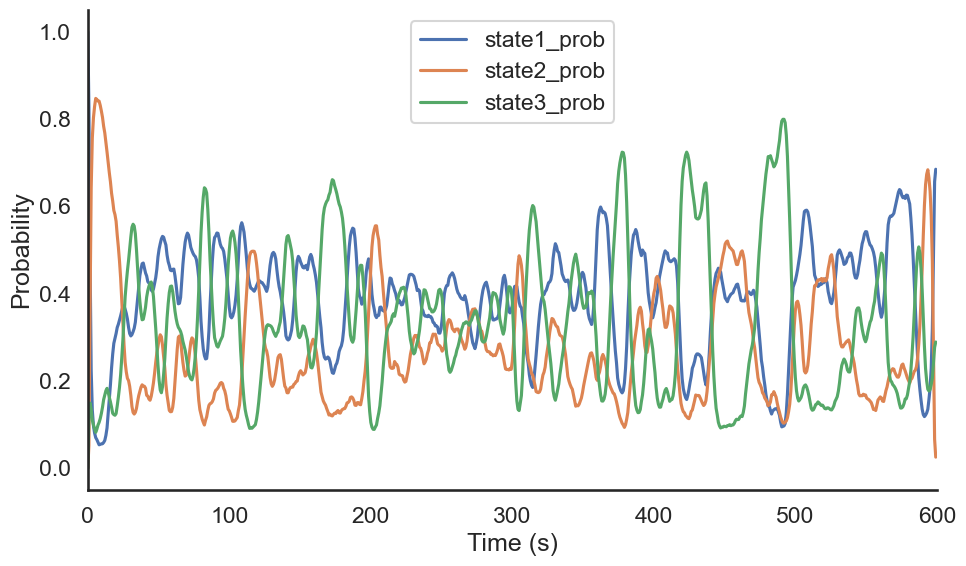

In [3]:
# plot mean probabilities
mean_prob = pd.read_csv(os.path.join(out_folder, 'movie{0}_k3_meanprobs.csv'.format(movie)), index_col=0)
mean_prob.plot(xlim=(0,600), figsize=(10,6))
sns.despine()
plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.tight_layout()
plt.show()
plt.close()

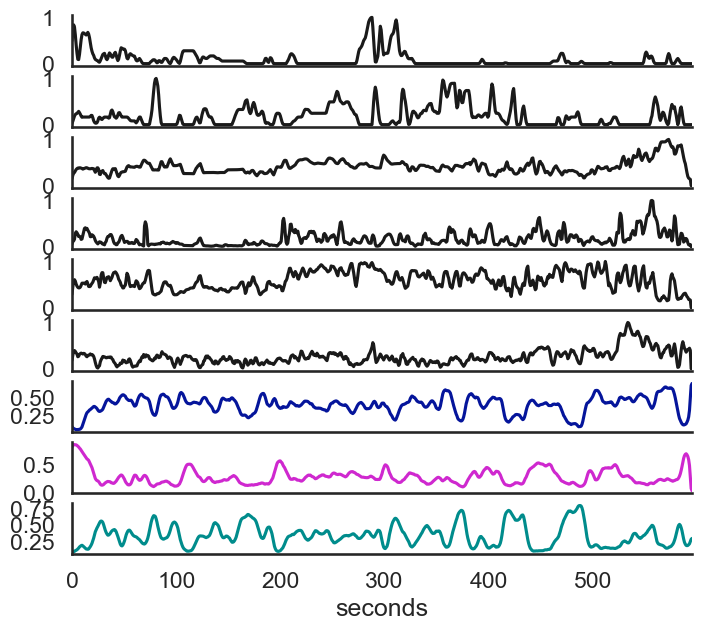

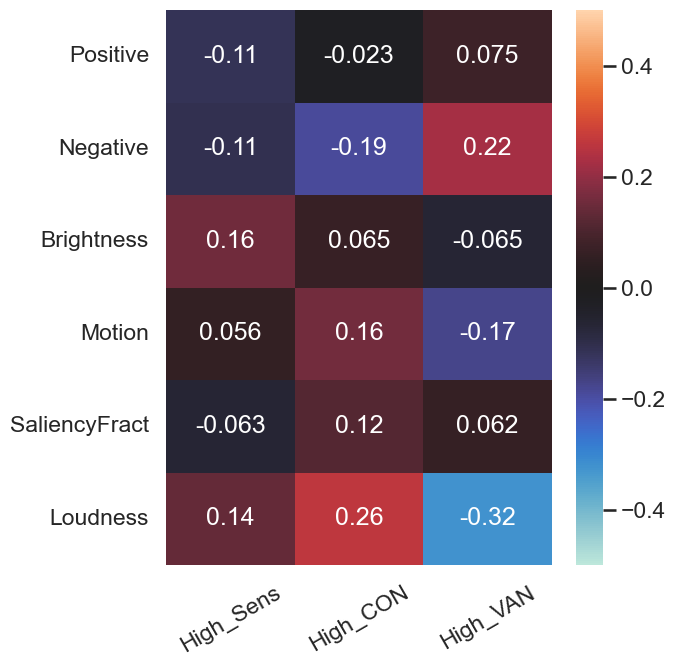

In [4]:
features = pd.read_csv(os.path.join(hbn_folder, 'HBN_video_coding','processing','v1','summary',
                                    '{0}_summary_codes_intuitivenames.csv'.format(movie)), 
                       index_col=0).loc[:, features_of_interest]

for f in features.columns:
    if features.loc[:,f].dtype=='float64':
        features.loc[:,f] = temporal_smooth(features.loc[:,f], timing, 1.2)
        
    features.loc[:,f] = MinMaxScaler().fit_transform(features.loc[:,f].to_frame().to_numpy())

features = features.iloc[:-5,:]
mean_prob_trim = mean_prob.iloc[5:,:]
mean_prob_trim.columns = ['High_Sens','High_CON','High_VAN']
mean_prob_trim.index = features.index
combo = features.merge(mean_prob_trim, how='left', left_index=True, right_index=True)



axes = combo[['Positive','Negative','Brightness','Motion','SaliencyFract','Loudness','High_Sens','High_CON',
       'High_VAN']].plot(subplots=True, figsize=(8,7), xlim=(0,timing[-6]), legend=False, 
                                  color=['k','k','k','k','k','k']+state_palette[1:])

sns.despine()
#plt.tight_layout()
plt.savefig(os.path.join(out_folder,'group-movie{0}_k3_mean_probabilities_features.png'.format(movie)), dpi=300)
plt.show()
plt.close()

c = combo.corr(method='spearman')
plt.figure(figsize=(7,7))
sns.heatmap(c.loc[['Positive','Negative','Brightness','Motion','SaliencyFract','Loudness'],
                  ['High_Sens','High_CON','High_VAN']], center=0, vmax=0.5, vmin=-0.5, annot=True)
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(os.path.join(out_folder,'group-movie{0}_k3_corr_probabilities_features.png'.format(movie)), dpi=300)

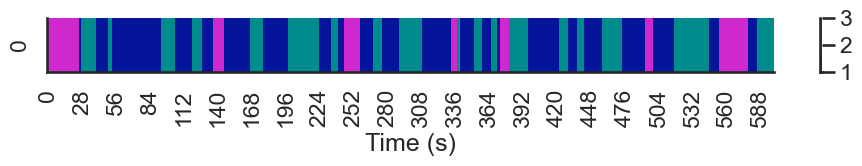

In [5]:
# assign state for each frame
states = ['High_Sens','High_CON','High_VAN']
combo.loc[:, 'state'] = 1
for i in range(len(combo.index)):
    ind = np.argmax(combo.iloc[i,-4:-1])
    if 'CON' in states[ind]:
        combo.iloc[i, -1] = 2
    elif 'VAN' in states[ind]:
        combo.iloc[i, -1] = 3

plt.figure(figsize=(10,2))
sns.heatmap(combo.loc[:,'state'].to_frame().T.to_numpy(), cmap=state_palette[1:])
plt.xlim(0, 600)
plt.xlabel('Time (s)')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder,'group_level_state_assignment_k3.png'), dpi=300)
plt.show()
plt.close()

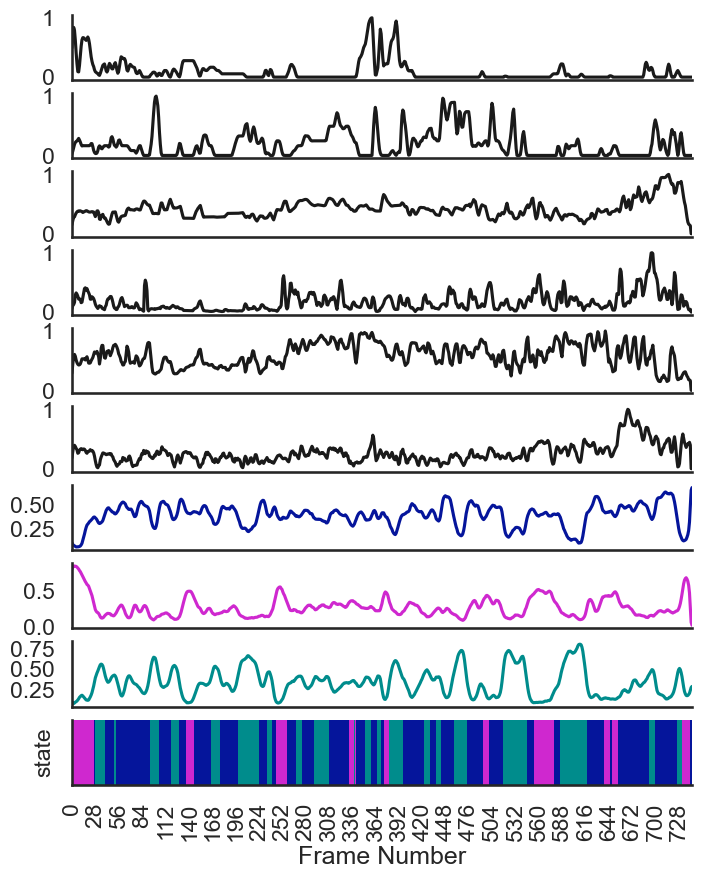

In [7]:
combo = combo.reset_index()
fig, ax = plt.subplots(10,1,sharex=True, figsize=(8,10))
features = ['Positive','Negative','Brightness','Motion','SaliencyFract','Loudness']

colors = ['k','k','k','k','k','k']+state_palette[1:]
for i, f in enumerate(features + states):
    ax[i].plot(combo.index, combo.loc[:,f], color=colors[i])
    #ax[i].set_title(f)
    ax[i].set_xlim(0,744)
sns.heatmap(combo.loc[:,'state'].to_frame().T, cmap=state_palette[1:], ax=ax[9], cbar=False)
ax[9].set_xlim(0,744)
plt.xlabel('Frame Number')
#plt.tight_layout()
sns.despine()
plt.savefig(os.path.join(out_folder,'group-movie{0}_k3_mean_probabilities_features_states.png'.format(movie)), dpi=300)

plt.show()
plt.close()

In [79]:
mean_prob_trim = mean_prob.iloc[5:,:]
mean_prob_trim.index = features.index
combo = features.merge(mean_prob_trim, how='left', left_index=True, right_index=True)
combo.head()

,Positive,Negative,Anger,Happy,Fear,Sad,Excited,Body,Face,SpokenWords,...,Brightness,SaliencyFract,Sharpness,Vibrance,Loudness,Motion,state1_prob,state2_prob,state3_prob,state
seconds,,,,,,,,,,,,,,,,,,,,,
0.0,0.494516,0.025725,0.000000,0.0,0.000000,0.0,0.345540,1,1,0,...,0.151599,0.290174,0.556330,0.102509,0.182047,0.058117,0.097519,0.803192,0.099288,2.0
0.8,0.721104,0.074033,0.002678,0.0,0.006808,0.0,0.490789,1,1,0,...,0.223077,0.454758,0.817779,0.151241,0.295970,0.111043,0.080735,0.828928,0.090338,2.0
1.6,0.838761,0.132237,0.035158,0.0,0.007679,0.0,0.537934,1,1,0,...,0.277077,0.575753,1.000000,0.184196,0.382563,0.126123,0.070212,0.847454,0.082334,2.0
2.4,0.790357,0.185837,0.080436,0.0,0.006808,0.0,0.467889,1,1,1,...,0.284015,0.605947,1.000000,0.185266,0.393200,0.161128,0.065594,0.844954,0.089452,2.0
3.2,0.623629,0.219125,0.131708,0.0,0.004745,0.0,0.328469,1,1,1,...,0.319916,0.574584,0.921053,0.185973,0.373790,0.288001,0.059510,0.841559,0.098931,2.0


In [8]:
means = pd.DataFrame(columns=features_of_interest)
for state in np.unique(combo['state']):
    means.loc[state, :] = combo.loc[combo['state']==state, features_of_interest].mean(axis=0)

means

,Positive,Negative,Anger,Happy,Fear,Sad,Excited,Body,Face,SpokenWords,WrittenWords,Brightness,SaliencyFract,Sharpness,Vibrance,Loudness,Motion
1,0.074322,0.195718,0.093736,0.066261,0.053129,0.058003,0.019651,0.946429,0.918367,0.530612,0.17602,0.43976,0.605221,0.904438,0.237002,0.277789,0.177594
2,0.150087,0.097646,0.057285,0.052732,0.035771,0.018546,0.073702,0.672414,0.689655,0.534483,0.163793,0.38671,0.53567,0.897393,0.188385,0.29863,0.199471
3,0.106028,0.23317,0.107498,0.103692,0.07325,0.059528,0.028685,0.966245,0.949367,0.582278,0.160338,0.39,0.598916,0.925797,0.239153,0.206448,0.143669


In [10]:
emo_f = ['Positive', 'Negative','Anger','Happy','Fear','Sad','Excited']
bin_f = ['Body','Face','SpokenWords','WrittenWords']
ll_f = ['Brightness','SaliencyFract','Sharpness','Vibrance','Loudness','Motion']

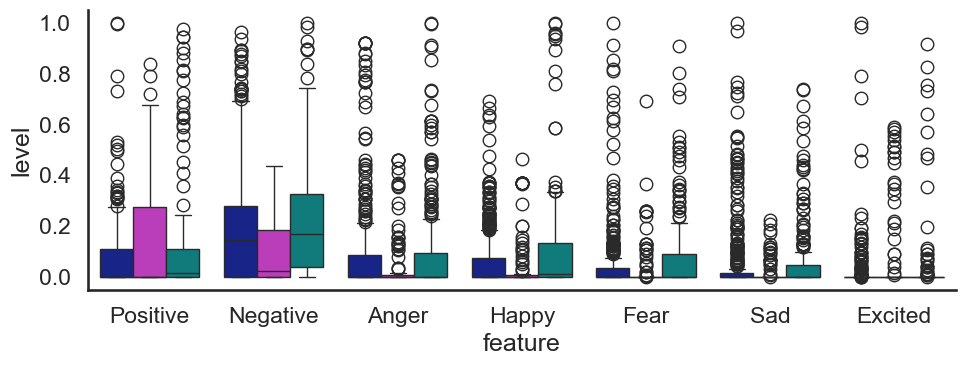

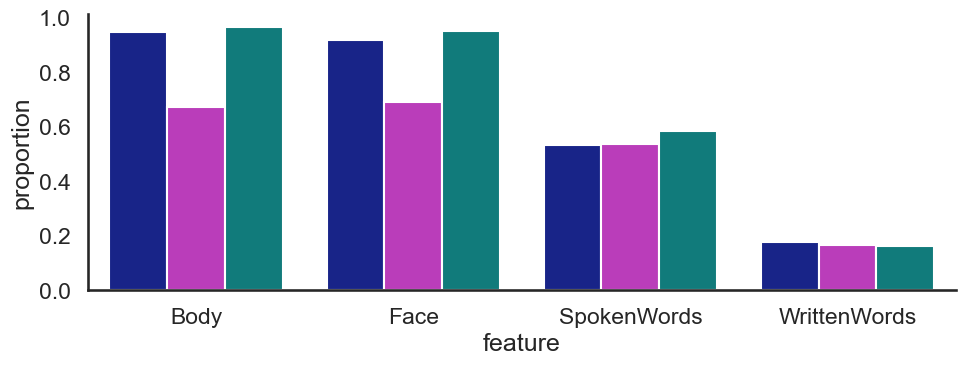

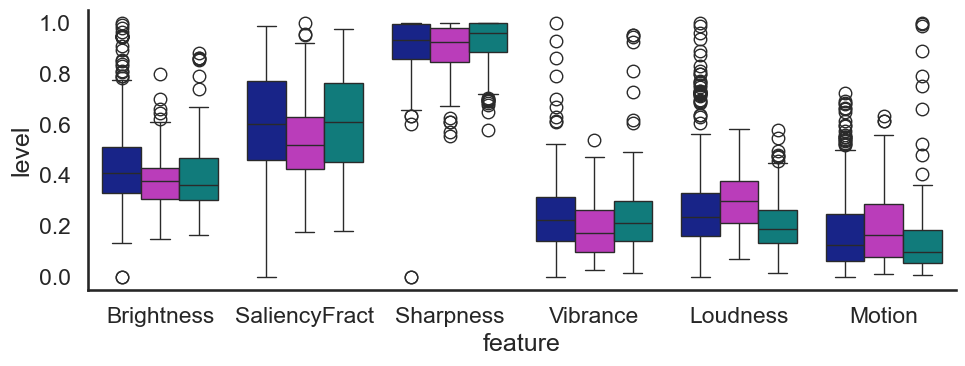

In [11]:
long_emo_features = pd.melt(combo.loc[:,emo_f + ['state']], id_vars='state',value_vars=emo_f, 
                            var_name='feature',value_name='level')

plt.figure(figsize=(10,4))
ax = sns.boxplot(x='feature',y='level',hue='state',data=long_emo_features,legend=False, palette=state_palette[1:])
#plt.xticks(rotation=20, ha='right')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'group_level_states_emofeatures_k3.png'), dpi=300)
plt.show()
plt.close()

long_bin_features = pd.melt(combo.loc[:,bin_f + ['state']], id_vars='state',value_vars=bin_f, 
                                var_name='feature',value_name='proportion')

plt.figure(figsize=(10,4))
ax = sns.barplot(x='feature',y='proportion',hue='state',data=long_bin_features,palette=state_palette[1:], errorbar=('ci', False), legend=False)
#plt.xticks(rotation=20, ha='right')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'group_level_states_binfeatures_k3.png'), dpi=300)
plt.show()
plt.close()

long_ll_features = pd.melt(combo.loc[:,ll_f + ['state']], id_vars='state',value_vars=ll_f, 
                                var_name='feature',value_name='level')

plt.figure(figsize=(10,4))
ax = sns.boxplot(x='feature',y='level',hue='state',data=long_ll_features,palette=state_palette[1:], legend=False)
#plt.xticks(rotation=20, ha='right')
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(out_folder, 'group_level_states_llfeatures_k3.png'), dpi=300)
plt.show()
plt.close()

In [12]:
#f = 'Body'
stats = pd.DataFrame(index=bin_f)
for f in bin_f:

    tab1 = pd.crosstab(combo.loc[combo['state']==1,'state'],combo.loc[combo['state']==1,f], 
                       normalize=True)*100
    tab1 = tab1.round(0).astype(int).T
    tab2 = pd.crosstab(combo.loc[combo['state']==2,'state'],combo.loc[combo['state']==2,f],
                       normalize=True)*100
    tab2 = tab2.round(0).astype(int).T
    tab3 = pd.crosstab(combo.loc[combo['state']==3,'state'],combo.loc[combo['state']==3,f],
                       normalize=True)*100
    tab3 = tab3.round(0).astype(int).T
    
    stats.loc[f,'s1vs2_stat'],stats.loc[f,'s1vs2_pval'] = scp.chisquare(tab1, tab2)
    stats.loc[f,'s1vs3_stat'],stats.loc[f,'s1vs3_pval'] = scp.chisquare(tab1, tab3)
    stats.loc[f,'s2vs3_stat'],stats.loc[f,'s2vs3_pval'] = scp.chisquare(tab2, tab3)
    stats.loc[f,'s1_prop1'] = tab1[1][1]
    stats.loc[f,'s2_prop1'] = tab2[2][1]
    stats.loc[f,'s3_prop1'] = tab3[3][1]
stats

,s1vs2_stat,s1vs2_pval,s1vs3_stat,s1vs3_pval,s2vs3_stat,s2vs3_pval,s1_prop1,s2_prop1,s3_prop1
Body,35.459068,2.604669e-09,1.374570,0.241028,309.278351,3.136402e-69,95.0,67.0,97.0
Face,24.731183,6.590914e-07,1.894737,0.168669,142.315789,8.295312e-33,92.0,69.0,95.0
SpokenWords,0.000000,1.000000e+00,1.026273,0.311036,1.026273,3.110357e-01,53.0,53.0,58.0
WrittenWords,0.297619,5.853789e-01,0.297619,0.585379,0.000000,1.000000e+00,18.0,16.0,16.0


In [13]:
for f in emo_f + ll_f:
    stats.loc[f,'s1vs2_stat'],stats.loc[f,'s1vs2_pval'] = scp.ttest_ind(combo.loc[combo['state']==1,f],combo.loc[combo['state']==2,f])
    stats.loc[f,'s1vs3_stat'],stats.loc[f,'s1vs3_pval'] = scp.ttest_ind(combo.loc[combo['state']==1,f],combo.loc[combo['state']==3,f])
    stats.loc[f,'s2vs3_stat'],stats.loc[f,'s2vs3_pval'] = scp.ttest_ind(combo.loc[combo['state']==2,f],combo.loc[combo['state']==3,f])
    stats.loc[f,'s1_mean'] = combo.loc[combo['state']==1,f].mean(axis=0)
    stats.loc[f,'s2_mean'] = combo.loc[combo['state']==2,f].mean(axis=0)
    stats.loc[f,'s3_mean'] = combo.loc[combo['state']==3,f].mean(axis=0)
    
stats.round(3).to_csv(os.path.join(out_folder, 'feature_state_stats.csv'))
stats.round(3)   

,s1vs2_stat,s1vs2_pval,s1vs3_stat,s1vs3_pval,s2vs3_stat,s2vs3_pval,s1_prop1,s2_prop1,s3_prop1,s1_mean,s2_mean,s3_mean
Body,35.459,0.000,1.375,0.241,309.278,0.000,95.0,67.0,97.0,NaN,NaN,NaN
Face,24.731,0.000,1.895,0.169,142.316,0.000,92.0,69.0,95.0,NaN,NaN,NaN
SpokenWords,0.000,1.000,1.026,0.311,1.026,0.311,53.0,53.0,58.0,NaN,NaN,NaN
WrittenWords,0.298,0.585,0.298,0.585,0.000,1.000,18.0,16.0,16.0,NaN,NaN,NaN
Positive,-4.532,0.000,-2.368,0.018,1.808,0.071,NaN,NaN,NaN,0.074,0.150,0.106
Negative,4.493,0.000,-2.007,0.045,-6.078,0.000,NaN,NaN,NaN,0.196,0.098,0.233
Anger,1.896,0.059,-0.837,0.403,-2.415,0.016,NaN,NaN,NaN,0.094,0.057,0.107
Happy,1.079,0.281,-3.001,0.003,-2.612,0.009,NaN,NaN,NaN,0.066,0.053,0.104
Fear,1.239,0.216,-1.692,0.091,-2.472,0.014,NaN,NaN,NaN,0.053,0.036,0.073
Sad,2.807,0.005,-0.129,0.898,-3.174,0.002,NaN,NaN,NaN,0.058,0.019,0.060
